# ch03 분류

- 가장 일반적인 지도 학습 작업이 회귀(예측)와 분류(클래스 예측)

## 지도학습

- 머신러닝 시스템을 학습하는 동안의 감독 형태나 정보량에 따라 분류한 것
- 지도학습, 비지도 학습, 준지도 학습, 강화 학습으로 나눌 수 있다.

### 지도 학습 supervised learning

- 지도 학습에는 알고리즘에 주입하는 훈련 데이터에 레이블이라는 원하는 답이 포함된다.

## 3.1 MNIST

- 사이킷런에서 제공하는 핼퍼 함수를 사용하여 데이터셋을 받을 수 있다.

In [1]:
# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original')

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

# Used for Confusion Matrix
from sklearn import metrics
import seaborn as sns

# Used for Loading MNIST
from struct import unpack

In [3]:
def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

In [4]:
train_img, train_lbl = loadmnist('./data/train-images.idx3-ubyte'
                                 , './data/train-labels.idx1-ubyte')
test_img, test_lbl = loadmnist('./data/t10k-images.idx3-ubyte'
                               , './data/t10k-labels.idx1-ubyte')

- train img 60000개, 각 이미지에는 784개의 특성이 있다.
- 이미지가 `28 * 28` 픽셀이기 때문에 784개
- 각 특성은 단순히 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타낸다.

In [5]:
train_img.shape

(60000, 784)

In [6]:
test_lbl.shape

(10000,)

In [7]:
test_img.shape

(10000, 784)

- 데이터셋에서 이미지 하나를 확인해보자.
- 샘플의 특성 벡터를 추출해서 `28 * 28` 배열로 크기를 바꾸고 matplotlib의 imshow() 함수를 사용해 그려보자.

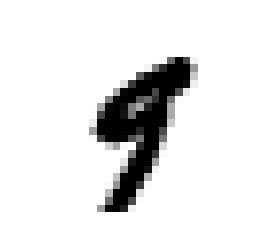

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = train_img[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
           interpolation='nearest')
plt.axis('off')
plt.show()

- 실제 레이블을 확인해보자.

In [9]:
train_lbl[36000], train_lbl[7]

(9, 3)

In [10]:
for n in range(10, 20):
    print(train_lbl[n])

3
5
3
6
1
7
2
8
6
9


In [11]:
28*28

784

In [12]:
x_train = train_img
x_test = test_img
y_train = train_lbl
y_test = test_lbl

## 3.2 이진 분류기 훈련

- 5와 5 아님 두 개의 클래스를 구분할 수 있는 이진 분류기
- 분류 작업을 위해 타깃 벡터를 만들어본다.
- 5만 True, 나머지는 False로 만든다.

In [21]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test)

- 분류 모델을 하나 선택해서 훈련시킨다.
- 사이킷런의 SGDClassifier 클래스를 사용해 확률적 경사 하강법 Stochastic Gradient Descent(SGD) 분류기를 사용한다.
- 이 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점. 온라인 학습에 잘 맞는다.

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

- SGDClassifier는 훈련하는데 무작위성을 사용한다.
- 그래서 이름에 확률적 stochastic 이 붙었다.
- 결과를 재현하고 싶다면 random_state 매개변수를 지정해야 한다.

In [15]:
sgd_clf.predict([some_digit]), sgd_clf.predict([x_train[11]]), 

(array([False]), array([ True]))

In [16]:
y_train[36000], y_train[11]

(9, 5)

- 분류기는 이미지가 5인지 아닌지 판단했다.
- 모델의 성능을 측정해보자.

## 3.3 성능측정

### 3.3.1 교차 검증을 사용한 정확도 측정

- cross_val_score() 함수로 폴드가 3개인 K-겹 교차 검증을 사용하여 SGDClassifier 모델을 평가한다.
- K-겹 교차 검증은 훈련 세트를 K개의 폴드로 나누고 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용한다.

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.9532 , 0.95125, 0.9625 ])

- 모든 교차 검증 폴드에 대해 정확도 accuracy (정확한 예측의 비율)가 95% 이상이다.
- 모든 이미지를 5 아님 클래스로 분류하는 더미 분류기를 만들어 비교해보자.

In [18]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier()

In [20]:
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

- 정확도가 90% 이상이다.
- 이미지의 10% 정도만 숫자 5이기 때문에 무조건 5아님으로 예측하면 정확히 맞출 확률이 90%다.
- 이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이류를 보여준다.
- 특히 불균형한 데이터셋을 다룰 때 즉, 어떤 클래스가 다른 것보다 월등히 많은 경우 더욱 그렇다.

### 3.3.2 오차 행렬

- 분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬 confusion matrix을 조사하는 것이다.
- 기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것.
- 예를 들어 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5 row, 3 col을 보면 된다.

- 오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 예측값을 만들어야 한다.
- 테스트 세트로 예측을 만들 수 있지만 여기서는 사용하면 안된다.
- 대신 cross_val_predict() 함수를 사용할 수 있다.

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

- cross_val_predict() 함수는 cross_val_score() 함수처럼 K-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다.

- confusion_matrix() 함수를 사용하여 오차 행렬을 만들 준비가 되었다.
- 타깃 클래스(y_train_5)와 예측 클래스(y_train_pred)를 넣고 호출하면 된다.

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52992,  1587],
       [ 1074,  4347]], dtype=int64)

- 오차 행렬의 row는 실제 클래스를 나타내고 col은 예측한 클래스를 나타낸다.


In [25]:
# confusion_matrix(y_train_5, y_tra)

### 3.3.3 정밀도와 재현율

- 사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공한다.

In [24]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7325581395348837

In [26]:
recall_score(y_train_5, y_train_pred)

0.8018815716657444

- 5로 판별된 이미지 중 77%만 정확하다.
- 전체 숫자 5에서 80%만 감지했다.